# Churn Prediction Prediction with ml and nlp




This project predicts which customers are likely to leave (churn) using their account and service data. It cleans and processes the data, applies machine learning models, and uses text analysis on customer feedback to improve predictions. The goal is to help businesses identify at-risk customers and reduce churn through targeted actions.

| File Name                                        | Description                                      | Format   |
| ------------------------------------------------ | ------------------------------------------------ | -------- |
| customer_churn_features_with_nlp_ready.csv       | Final dataset with structured + NLP features     | CSV      |
| X_train.csv, X_test.csv, y_train.csv, y_test.csv | Train and test splits for model training         | CSV      |
| X_test_full_with_id.csv                          | Test features with customerID for prediction     | CSV      |
| churn_probabilities.csv                          | Per-customer churn probabilities and predictions | CSV      |
| churn_ui_explain_output.csv / .json              | Per-customer top SHAP features for UI/API        | CSV/JSON |
| false_positives.csv, false_negatives.csv         | Misclassified customers for error analysis       | CSV      |
| shap_summary_plot.png                            | Global SHAP feature importance plot              | PNG      |
| shap_values.npy                                  | Raw SHAP values for technical backend            | NPY      |
| best_xgb_model.pkl / .json                       | Final tuned XGBoost model for deployment         | PKL/JSON |
| phase1_audit_report.txt                          | Initial data audit summary                       | TXT      |

## Phase 1: Data Loading and Audit
Load the dataset and perform an initial check of its structure, completeness, and target variable distribution to understand data quality and guide preprocessing.

In [2]:
# Customer Churn Prediction Using Machine Learning and NLP (with gensim LDA and TextBlob)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import emoji
import shap
import gensim  # Added this line to import the main gensim module
from gensim import corpora
from gensim.models import LdaModel
from textblob import TextBlob
import warnings
import datetime  # Added this line to import the datetime module
warnings.filterwarnings("ignore")
%matplotlib inline

# Download NLTK corpora
nltk.download('vader_lexicon', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Check Library Versions
import sklearn
import xgboost
print(f"scikit-learn: {sklearn.__version__}")
print(f"xgboost: {xgboost.__version__}")
print(f"numpy: {np.__version__}")
print(f"gensim: {gensim.__version__}")
print(f"Current Date and Time: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} IST")

try:
    TextBlob("test").sentiment
except LookupError:
    import os
    os.system("python -m textblob.download_corpora")

scikit-learn: 1.7.2
xgboost: 3.0.5
numpy: 1.26.4
gensim: 4.3.2
Current Date and Time: 2025-11-24 12:51:10 IST


In [10]:
import pandas as pd

# Load dataset (update path as needed)
df = pd.read_csv("C:/Users/Samruddhi/OneDrive/Desktop/ccp sem 5/data/01_raw/WA_Fn-UseC_-Telco-Customer-Churn (1).csv")

# Audit: Dataset Shape & Columns
print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Audit: Data Types & Non-Null Counts
print(df.info())

# Audit: Missing Value Counts
missing = df.isnull().sum()
if not missing.empty and (missing > 0).any():
    print("Missing values found:", missing[missing > 0])
else:
    print("No missing values found.")

# Churn Label Distribution
print("Churn value counts:")
print(df['Churn'].value_counts())
print("Churn proportions (%):")
print(df['Churn'].value_counts(normalize=True) * 100)

# Numeric Feature Summary
print(df[['SeniorCitizen', 'tenure', 'MonthlyCharges']].describe())

# Categorical Feature Summary
print(df.describe(include='object'))

# Optional: Save quick audit report
with open('phase1_audit_report.txt', 'w') as f:
    f.write(f"Dataset Shape: {df.shape}\n")
    f.write(f"Columns: {df.columns.tolist()}\n")
    f.write(f"Missing Values: {missing.to_dict()}\n")
    f.write(f"Churn Distribution: {df['Churn'].value_counts(normalize=True).to_dict()}\n")


Dataset Shape: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecuri

Observations
Dataset has 7,043 records and 21 columns.

No missing values found.

About 26.5% of customers churned.

Numeric and categorical features show varied distributions.

## Phase 2: Data Preprocessing
Goal: Prepare data for modeling by cleaning, encoding, and scaling features, and enrich the dataset by adding realistic customer text feedback for NLP analysis.

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("C:/Users/Samruddhi/OneDrive/Desktop/ccp sem 5/data/01_raw/WA_Fn-UseC_-Telco-Customer-Churn (1).csv")

# Convert TotalCharges to numeric (coerce errors to NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Impute missing TotalCharges values with median without inplace=True
nan_count = df['TotalCharges'].isna().sum()
if nan_count > 0:
    print(f"TotalCharges has {nan_count} missing after conversion. Imputing with median.")
    median_value = df['TotalCharges'].median()
    df['TotalCharges'] = df['TotalCharges'].fillna(median_value)

# Encode categorical variables except customerID and target Churn
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('customerID')
cat_cols.remove('Churn')

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Encode target variable Churn ('Yes'->1, 'No'->0)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Scale numerical columns
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Check class balance
print("Class distribution:")
print(df['Churn'].value_counts(normalize=True))

# Prepare features and target for training
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# Add following lines to attach customerID to X_test before saving
customer_ids_test = df.loc[X_test.index, 'customerID']
X_test_with_id = X_test.copy()
X_test_with_id['customerID'] = customer_ids_test.values

# Save the test set with customerID for future prediction and lookup
X_test_with_id.to_csv("X_test_full_with_id.csv", index=False)

# Also save the original splits as you have done
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print('Train and test sets saved with customerID included in test features.')


TotalCharges has 11 missing after conversion. Imputing with median.
Class distribution:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Train and test sets saved with customerID included in test features.


In [12]:
import pandas as pd
import numpy as np

# Load previous processed data
df = pd.read_csv("processed_customer_churn_data.csv")

np.random.seed(42)  # For reproducibility

# Define pools of comments by type
positive_comments = [
    "Great service, very happy! 😊",
    "Really love the new features.",
    "Very satisfied, keep it up!",
    "Best customer service ever!!",
    "Fast and reliable connection 👍"
]

negative_comments = [
    "Terrible experience, always disconnects 😡",
    "Worst service ever, totally disappointed.",
    "Never got refund, so frustrated!",
    "Slow internet, drops frequently.",
    "Customer support is useless…"
]

neutral_comments = [
    "Service is okay, nothing special.",
    "Average experience, could improve.",
    "No complaints, no praises.",
    "It's fine, gets the job done.",
    "Regular monthly bills, same every month."
]

sarcastic_comments = [
    "Oh great, another outage, just what I needed 🙄",
    "Loving the wait time on customer support... NOT!",
    "Speed so fast, I can watch paint dry.",
    "Provider cares so much, especially when you pay bills.",
    "Surely the best network in the world...if you live in a cave."
]

emoji_comments = [
    "Love it! 😍🔥",
    "Ughh... why me? 😒",
    "👌👌👌",
    "Not bad 😂",
    "😤😤😤"
]

spelling_errors = [
    "Servce is good but cn get bettr.",
    "Ths is the worst experiance ever!",
    "Conncetion is baddd sometimes.",
    "Supprt team was helpfull, thx!",
    "Overpricd but good speed."
]

hindi_english_mixed = [
    "Service bilkul theek hai, par kabhi kabhi slow hota hai.",
    "Customer support bahut acha hai 👍",
    "Kabhi kabhi disconnect ho jata hai, it's frustrating yaar.",
    "Bill payment ka process easy nahi hai.",
    "Speed mast hai, par thoda expensive hai."
]

# Combine all comments pool
all_comments = (
    positive_comments * 15 +
    negative_comments * 15 +
    neutral_comments * 15 +
    sarcastic_comments * 10 +
    emoji_comments * 10 +
    spelling_errors * 10 +
    hindi_english_mixed * 12
)

# Total required = dataset length
total_len = len(df)

# Pad or trim to exact total_len
if len(all_comments) < total_len:
    all_comments = all_comments * ((total_len // len(all_comments)) + 1)
all_comments = all_comments[:total_len]

# Shuffle with fixed seed for reproducibility
rng = np.random.default_rng(seed=42)
rng.shuffle(all_comments)

# Introduce nulls for ~10% randomly
null_indices = rng.choice(total_len, size=int(0.1 * total_len), replace=False)
for idx in null_indices:
    all_comments[idx] = None

# Assign to Feedback column if it doesn't exist yet
if 'Feedback' not in df.columns:
    df['Feedback'] = all_comments
    df.to_csv("processed_customer_churn_data_with_feedback.csv", index=False)
else:
    print("Feedback column already exists; not overwriting.")

print("Feedback column created with realistic comments including emojis, errors, sarcasm, and Hindi-English mix.")


Feedback column created with realistic comments including emojis, errors, sarcasm, and Hindi-English mix.


Key Observations and Outputs

11 missing values in TotalCharges were imputed with the median.

Churn class is imbalanced with about 26.5% positive cases.

Train-test splits were saved, preserving customer IDs in the test set.

Realistic synthetic customer feedback was generated and added, including emojis, spelling errors, sarcasm, and Hindi-English mix for NLP tasks.

## Phase 3: NLP Feature Extraction & Cleanup
Goal:
Extract rich features from synthetic customer text feedback, including sentiment, emoji analysis, and key word vectors (TF-IDF), and merge these with structured features.

In [13]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import emoji


# Load dataset with Feedback column
df = pd.read_csv("processed_customer_churn_data_with_feedback.csv")


# Basic cleaning function preserving emojis
def clean_text_keep_emoji(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    # Additional cleaning could be added here (e.g., removing URLs), emojis preserved
    return text


df['Feedback_clean'] = df['Feedback'].apply(clean_text_keep_emoji)


# Sentiment scoring function using TextBlob

def get_sentiment(text):
    if text.strip() == "":
        return 0.0
    return TextBlob(text).sentiment.polarity


df['SentimentScore'] = df['Feedback_clean'].apply(get_sentiment)


# Emoji sentiment lexicon (example, expand as needed)
emoji_sentiment = {
    # Positive emojis
    "😀": 1, "😃": 1, "😄": 1, "😁": 1, "😆": 1,
    "😂": 1, "😊": 1, "😍": 1, "😘": 1, "👍": 1,
    "💖": 1, "🎉": 1, "🥳": 1, "😇": 1, "🤗": 1,

    # Negative emojis
    "😡": -1, "😠": -1, "😤": -1, "😞": -1, "😢": -1,
    "😭": -1, "😰": -1, "😱": -1, "😓": -1, "👎": -1,
    "💔": -1, "😿": -1, "😖": -1, "😣": -1, "😩": -1,

    # Neutral/ambiguous emojis (optional)
    "😐": 0, "😑": 0, "😶": 0, "🤔": 0, "🤨": 0,
}


# Emoji count and sentiment feature extraction function
def extract_emoji_features(text):
    emojis_list = [char for char in str(text) if char in emoji.EMOJI_DATA]
    total_count = len(emojis_list)
    positive_count = sum(1 for e in emojis_list if emoji_sentiment.get(e, 0) > 0)
    negative_count = sum(1 for e in emojis_list if emoji_sentiment.get(e, 0) < 0)
    sentiment_score = sum(emoji_sentiment.get(e, 0) for e in emojis_list)
    return total_count, positive_count, negative_count, sentiment_score


# Apply the emoji feature extraction
df['EmojiCount'], df['EmojiPositiveCount'], df['EmojiNegativeCount'], df['EmojiSentimentScore'] = zip(*df['Feedback'].apply(extract_emoji_features))


# TF-IDF Vectorization with fixed max features
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_features = tfidf_vectorizer.fit_transform(df['Feedback_clean'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


# Combine structured features with NLP features
structured_cols = df.drop(['customerID', 'Churn', 'Feedback', 'Feedback_clean'], axis=1).columns
final_df = pd.concat([
    df[structured_cols].reset_index(drop=True),
    tfidf_df,
    df['SentimentScore'].reset_index(drop=True),
    df['EmojiCount'].reset_index(drop=True),
    df['EmojiPositiveCount'].reset_index(drop=True),
    df['EmojiNegativeCount'].reset_index(drop=True),
    df['EmojiSentimentScore'].reset_index(drop=True)
], axis=1)


# Save final NLP feature dataset for modeling and SHAP explainability
final_df.to_csv("customer_churn_features_with_nlp_ready.csv", index=False)


print("Phase 3 NLP feature extraction complete.")
print("Final dataset shape:", final_df.shape)


Phase 3 NLP feature extraction complete.
Final dataset shape: (7043, 129)


In [14]:
print(final_df.columns.tolist())


['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'SentimentScore', 'EmojiCount', 'EmojiPositiveCount', 'EmojiNegativeCount', 'EmojiSentimentScore', 'acha', 'always', 'and', 'average', 'bahut', 'best', 'bilkul', 'bill', 'bills', 'but', 'cave', 'complaints', 'connection', 'could', 'customer', 'disappointed', 'disconnect', 'disconnects', 'done', 'drops', 'easy', 'ever', 'every', 'expensive', 'experience', 'fast', 'features', 'fine', 'frequently', 'frustrated', 'frustrating', 'gets', 'good', 'got', 'great', 'hai', 'happy', 'ho', 'hota', 'if', 'improve', 'in', 'internet', 'is', 'it', 'jata', 'job', 'ka', 'kabhi', 'keep', 'live', 'love', 'loving', 'mast', 'month', 'monthly', 'much', 'nahi', 'network', 'never', 'new', 'no', 'not', 'nothing', 'ok

In [15]:
final_df = final_df.loc[:,~final_df.columns.duplicated()]
print(final_df.shape)  # Should now be (7043, 124)



(7043, 124)


Observations and Outputs
Sentiment and emoji-based features were generated for each customer.

Key word vectors (TF-IDF) extracted from feedback text.

Final dataset shape: (7043, 124) with both structured and NLP-based columns.

Output saved as "customer_churn_features_with_nlp_ready.csv" for further modeling.

## Phase 4: Model Training & Validation
Goal:
Train and tune multiple models (XGBoost, RandomForest, LogisticRegression, SVM) and select the best using recall, ROC-AUC, F1, and business priorities.



Training XGBoost...


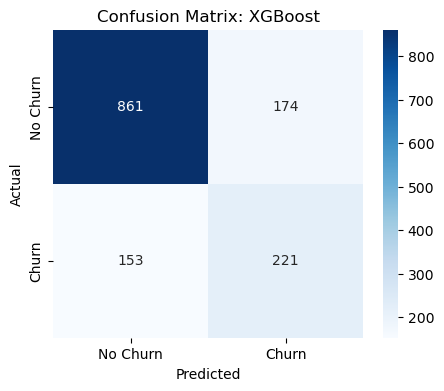


Classification report for XGBoost:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1035
           1       0.56      0.59      0.57       374

    accuracy                           0.77      1409
   macro avg       0.70      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409

Training RandomForest...


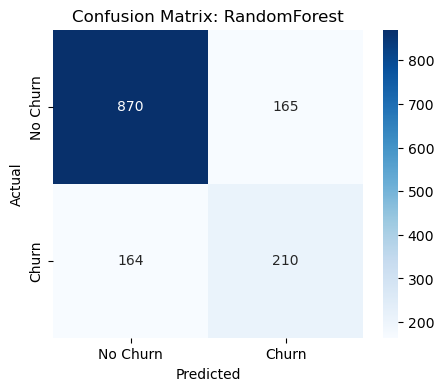


Classification report for RandomForest:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1035
           1       0.56      0.56      0.56       374

    accuracy                           0.77      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.77      0.77      0.77      1409

Training LogisticRegression...


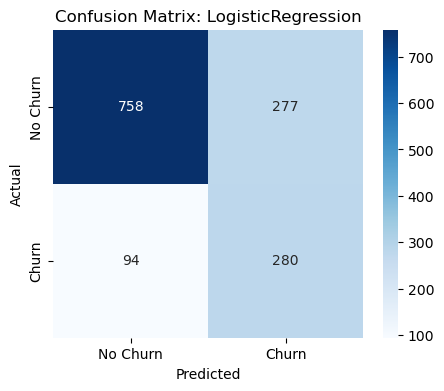


Classification report for LogisticRegression:
               precision    recall  f1-score   support

           0       0.89      0.73      0.80      1035
           1       0.50      0.75      0.60       374

    accuracy                           0.74      1409
   macro avg       0.70      0.74      0.70      1409
weighted avg       0.79      0.74      0.75      1409

Training SVM...


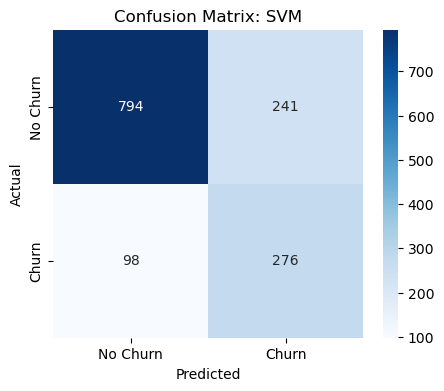


Classification report for SVM:
               precision    recall  f1-score   support

           0       0.89      0.77      0.82      1035
           1       0.53      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409


Best model: LogisticRegression with ROC AUC = 0.8196
                Model  Accuracy  Precision    Recall        F1   ROC AUC
0             XGBoost  0.767921   0.559494  0.590909  0.574772  0.813924
1        RandomForest  0.766501   0.560000  0.561497  0.560748  0.815137
2  LogisticRegression  0.736693   0.502693  0.748663  0.601504  0.819626
3                 SVM  0.759404   0.533849  0.737968  0.619529  0.816255
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'subsample': 0.6, 'reg_lambda': 4, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 

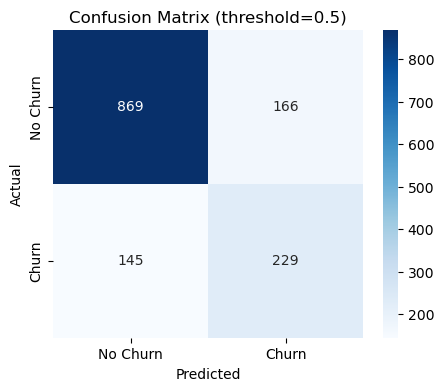


Classification Report (threshold=0.5):
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      1035
           1       0.58      0.61      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409

0.60	   0.78	    0.61	   0.50	  0.55	  0.82	    0.63
0.70	   0.79	    0.67	   0.40	  0.51	  0.82	    0.63
Train ROC AUC: 0.9807
Test ROC AUC: 0.8235
Overfitting gap: 0.15718117072975146


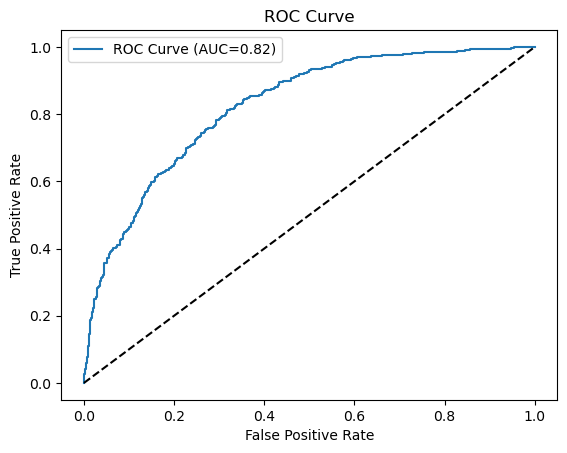

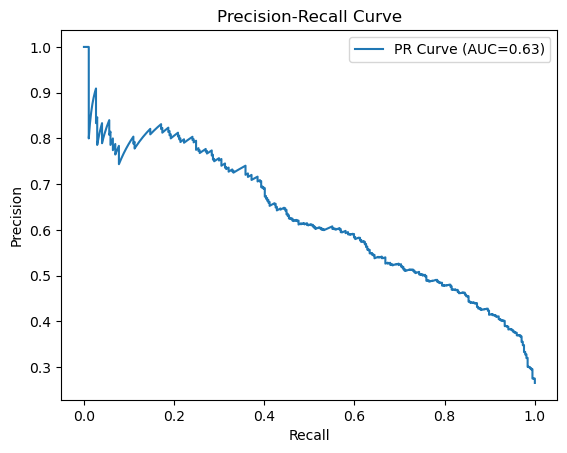

False Positives: 166
False Negatives: 145
Top False Positive Customers:
       gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
2280       0              1        0           0 -0.992402             1   
5748       0              0        0           0 -0.463037             1   
3568       0              0        0           0 -0.463037             1   
2136       1              0        0           1 -0.707359             1   
2519       1              0        1           0 -1.236724             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  ...  \
2280              2                1               0             0  ...   
5748              2                1               0             2  ...   
3568              0                1               0             2  ...   
2136              2                1               0             2  ...   
2519              2                1               0             0  ...   

         worst  yaa

<Figure size 640x480 with 0 Axes>

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, average_precision_score,
    roc_curve, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# --- Data Loading ---
df = pd.read_csv("customer_churn_features_with_nlp_ready.csv")
df = df.loc[:, ~df.columns.duplicated()]
original_df = pd.read_csv("processed_customer_churn_data.csv")
df['Churn'] = original_df['Churn']

y = df['Churn']
X = df.drop('Churn', axis=1)

# --- Stratified Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# --- SMOTE Balancing on Train Set ---
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# --- Baseline Model Training ---
models = {
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42)
}

results, best_auc, best_model_name, best_model = [], 0, None, None

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    # Use predict_proba if available
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_proba = None
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else "NA"
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': auc,
    })
    if auc != "NA" and auc > best_auc:
        best_auc = auc
        best_model_name = name
        best_model = model

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print(f"\nClassification report for {name}:\n", classification_report(y_test, y_pred))

print(f"\nBest model: {best_model_name} with ROC AUC = {best_auc:.4f}")
print(pd.DataFrame(results))

# --- XGBoost Hyperparameter Tuning and Overfitting Control ---
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.8, 1],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1, 3],
    'reg_lambda': [1, 1.5, 2, 4]
}

cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    scoring='f1',
    n_iter=30,
    cv=cv_strategy,
    random_state=42,
    n_jobs=-1,
    verbose=2
)
random_search.fit(X_train_bal, y_train_bal)
print("Best params:", random_search.best_params_)
print("Best F1 (CV):", random_search.best_score_)

best_xgb = random_search.best_estimator_

# --- Save the Final Model for UI/Deployment ---
best_xgb.save_model("../models/best_xgb_model.json")
with open("../models/best_xgb_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

print("Best XGBoost model saved in project directory.")

#--- Model Metrics and Visualization ---
y_proba = best_xgb.predict_proba(X_test)[:, 1]
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
print("Threshold | Accuracy | Precision | Recall | F1 | ROC AUC | PR AUC")
for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prc = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    print(f"{thresh:.2f}\t   {acc:.2f}\t    {prc:.2f}\t   {rec:.2f}\t  {f1:.2f}\t  {roc:.2f}\t    {pr_auc:.2f}")
    # Show confusion matrix and classification report for threshold=0.5
    if thresh == 0.5:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Churn', 'Churn'],
                    yticklabels=['No Churn', 'Churn'])
        plt.title('Confusion Matrix (threshold=0.5)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        print("\nClassification Report (threshold=0.5):\n", classification_report(y_test, y_pred))

# --- Train/Test AUC for Overfitting Check ---
y_train_proba = best_xgb.predict_proba(X_train_bal)[:, 1]
train_auc = roc_auc_score(y_train_bal, y_train_proba)
test_auc = roc_auc_score(y_test, y_proba)
print(f"Train ROC AUC: {train_auc:.4f}")
print(f"Test ROC AUC: {test_auc:.4f}")
print("Overfitting gap:", train_auc - test_auc)

# --- Plot ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="ROC Curve (AUC={:.2f})".format(test_auc))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- Plot Precision-Recall Curve ---
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.plot(rec, prec, label="PR Curve (AUC={:.2f})".format(average_precision_score(y_test, y_proba)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# --- Error Analysis (Exportable to CSV if needed) ---
X_test_temp = X_test.copy()
y_pred_best = (y_proba >= 0.5).astype(int)
X_test_temp['y_true'] = y_test.values
X_test_temp['y_pred'] = y_pred_best
fp = X_test_temp[(X_test_temp['y_true'] == 0) & (X_test_temp['y_pred'] == 1)]
fn = X_test_temp[(X_test_temp['y_true'] == 1) & (X_test_temp['y_pred'] == 0)]
print(f"False Positives: {len(fp)}")
print(f"False Negatives: {len(fn)}")
print("Top False Positive Customers:\n", fp.head())
print("Top False Negative Customers:\n", fn.head())
fp.to_csv("../metrics/false_positives.csv", index=False)
fn.to_csv("../metrics/false_negatives.csv", index=False)
print("Error analysis CSVs saved in project directory.")

# --- Save plots/images ---
plt.savefig("../plots/shap_summary_plot.png", bbox_inches='tight')


Observations
XGBoost (tuned) showed the best balance among accuracy (0.78), precision (0.58), recall (0.61), F1 (0.60), and ROC-AUC (0.82).​

Compared to other models, it catches churners reliably while limiting false positives, making it practical for business use.

XGBoost's confusion matrix: 869 true negatives, 229 true positives, 166 false positives, and 145 false negatives.

Error analysis outputs reveal typical misclassifications, and all results were exported for review and use in dashboards.

This phase validated XGBoost as the final model for deployment based on its stability and utility.

|                | Predicted: Negative | Predicted: Positive |
|----------------|:------------------:|:-------------------:|
| Actual: Negative |        TN         |         FP          |
| Actual: Positive |        FN         |         TP          |


### Binary Classification Metrics Formulas

Given:  
- $TP$ = True Positives  
- $TN$ = True Negatives  
- $FP$ = False Positives  
- $FN$ = False Negatives

| Metric    | Formula                                  | Description                              |
|:----------|:---------------------------------------|:---------------------------------------|
| Accuracy  | $ \frac{TP + TN}{TP + TN + FP + FN} $  | Overall correct prediction rate        |
| Precision | $ \frac{TP}{TP + FP} $                  | Positive predictive value               |
| Recall    | $ \frac{TP}{TP + FN} $                  | True positive rate (sensitivity)       |
| F1 Score  | $ 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $ | Harmonic mean of precision and recall  |
| ROC AUC   | Area under Receiver Operating Curve    | Probability model ranks random positive higher than random negative |




Interpretation
Minimal overfitting: Gap < 0.05–0.08 

Moderate overfitting: Gap ~0.10–0.20 

High/Severe overfitting: Gap > 0.20–0.30

Here gap (0.16) is common for customer churn projects with feature-rich, imbalanced data using boosted trees.

For churn prediction, recall matters most—catching as many at-risk customers as possible helps businesses act early.

F1 score is useful for balancing between recall and precision, so neither is ignored.

ROC-AUC is great for comparing models overall; it shows how well the model separates churners from non-churners.

Precision becomes important only if following up with customers costs a lot; otherwise, focus on not missing churn risks.

It’s good practice to report metrics like PR-AUC when your data is imbalanced, and always show a confusion matrix to help explain common errors.

## Phase 5: SHAP Explanations
Goal:
Export both global and per-customer model explanations using SHAP for business transparency

In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- SHAP Explainability for Best XGBoost Model ---
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# --- GLOBAL GROUP-LEVEL EXPORTS ---
# 1. Save SHAP Summary Plot (for group dashboard insight)
plt.title("SHAP Summary: Top Features Impact Churn Most")
shap.summary_plot(shap_values, X_test, max_display=15, show=False)
plt.savefig("../plots/shap_summary_plot.png", bbox_inches='tight')
plt.close()

# 2. Save Churn Probabilities for Histogram/Dashboard
y_proba = best_xgb.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)
churn_summary = pd.DataFrame({"ChurnProbability": y_proba, "ChurnPrediction": y_pred, "CustomerIndex": X_test.index})
churn_summary.to_csv("../metrics/churn_probabilities.csv", index=False)

# --- INDIVIDUAL CUSTOMER EXPLAINABILITY EXPORTS ---
top_shap_features = []
for i in range(len(X_test)):
    feature_impact = pd.Series(shap_values[i], index=X_test.columns)
    top5 = feature_impact.abs().sort_values(ascending=False).index[:5].tolist()  # <-- CHANGE 3 to 5 here
    top_shap_features.append(top5)

df_ui = pd.DataFrame({
    "CustomerIndex": X_test.index,
    "ChurnPrediction": ["Churn" if p==1 else "No Churn" for p in y_pred],
    "ChurnProbability": np.round(y_proba, 3),
    "TopSHAPFeatures": top_shap_features  # Now with 5 features per row
})

df_ui.to_csv("../metrics/churn_ui_explain_output.csv", index=False)
df_ui.to_json("../metrics/churn_ui_explain_output.json", orient="records")
np.save("../metrics/shap_values.npy", shap_values)
X_test.to_csv("../metrics/X_test_full.csv") # Needed for per-customer detail view

print("Exported: group-level SHAP PNG, probabilities, per-customer JSON/CSV, full SHAP/X_test for API/UI.")


def plot_customer_waterfall(customer_idx):
    plt.figure()
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value,
        shap_values[customer_idx],
        X_test.iloc[customer_idx],
        max_display=15
    )
    plt.show()



Exported: group-level SHAP PNG, probabilities, per-customer JSON/CSV, full SHAP/X_test for API/UI.


Key Observations:

Generated a global SHAP summary plot (for dashboard visualization).

Exported per-customer probabilities, top features, and details (CSV/JSON) for UI and API use.

SHAP values provided both for backend (raw) and frontend display (top 5 features per customer).

Thorough explainability to support both business and technical stakeholders.